In [1]:
!pip install factor_analyzer
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from sklearn.metrics import accuracy_score, classification_report
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cross_decomposition import CCA

In [2]:
# Load the dataset
file_name = 'International_Education_Costs.csv'
df = pd.read_csv(file_name)

In [3]:
#checking null values
df.isnull().sum()

Country              0
City                 0
University           0
Program              0
Level                0
Duration_Years       0
Tuition_USD          0
Living_Cost_Index    0
Rent_USD             0
Visa_Fee_USD         0
Insurance_USD        0
Exchange_Rate        0
dtype: int64

In [4]:
# Drop Null Values
df.dropna(inplace=True)

In [5]:
# Select only continuous (numeric) columns in the new dataset
continuous_cols = [
    'Duration_Years','Tuition_USD','Living_Cost_Index','Rent_USD','Visa_Fee_USD','Insurance_USD','Exchange_Rate']
X = df[continuous_cols]

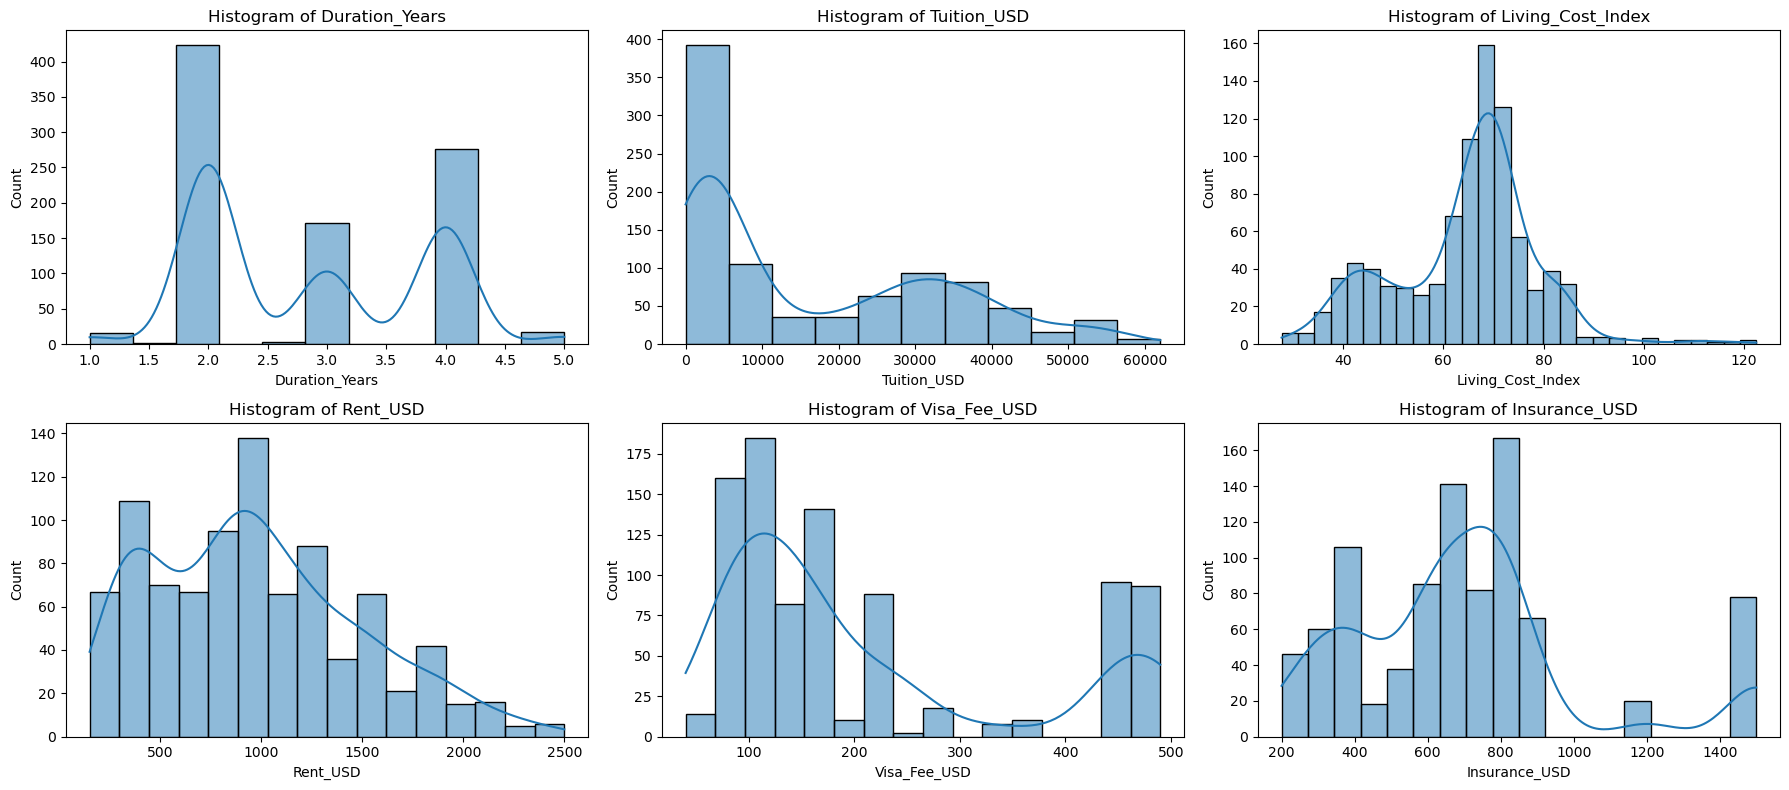

In [6]:
#Plot histograms of Numarical Variables
n_cols = 3
cols_to_plot = [col for col in continuous_cols if col != 'Exchange_Rate']
n_plots = len(cols_to_plot)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 4*n_rows))
axes = axes.flatten()  # Flatten in case of single row

# Plot histograms
for i, col in enumerate(cols_to_plot):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

# Hide any unused subplots
for i in range(n_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [7]:
# Correct skewness
for col in continuous_cols:
    if skew(df[col]) > 1:
        df[col] = np.log1p(df[col])
    elif skew(df[col]) < -1:
        df[col] = np.log1p(df[col].max() + 1 - df[col])

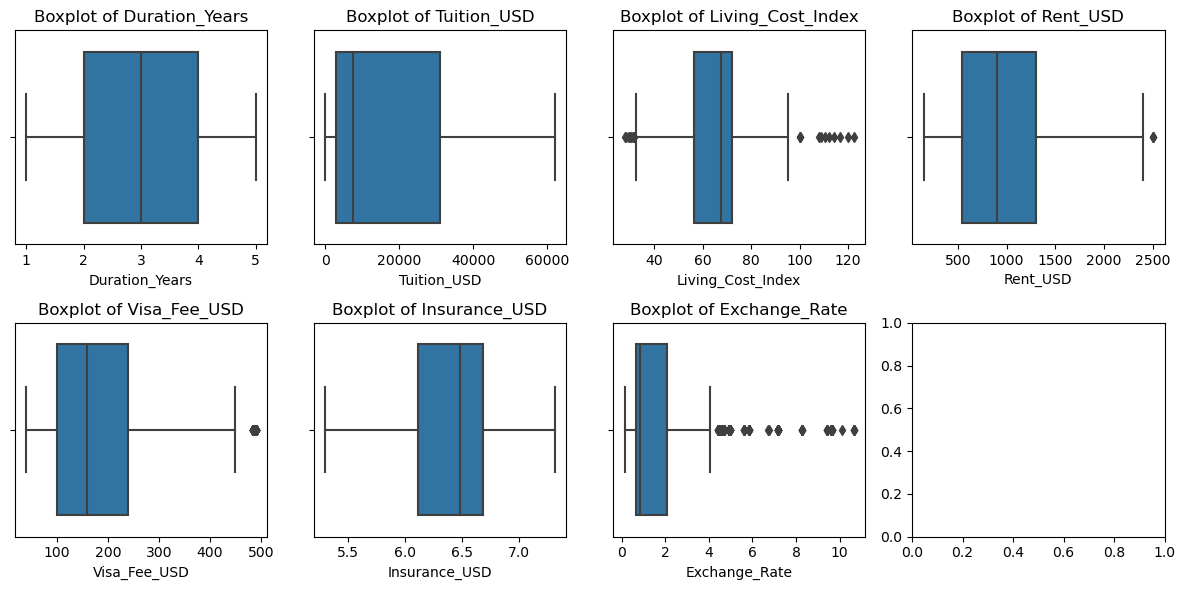

In [8]:
# Plot boxplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for ax, col in zip(axes.flatten(), continuous_cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [9]:
# Drop outliers using IQR method
Q1 = df[continuous_cols].quantile(0.25)
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[continuous_cols] < (Q1 - 1.5 * IQR)) | (df[continuous_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [10]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##Principal Component Analysis (PCA)

In [11]:
# Apply PCA
n_components = 7
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with principal components
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Print explained variance
print("Explained variance ratio for each component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.2%}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")

Explained variance ratio for each component:
PC1: 46.87%
PC2: 15.80%
PC3: 13.90%
PC4: 13.14%
PC5: 6.38%
PC6: 2.76%
PC7: 1.14%
Total explained variance: 100.00%


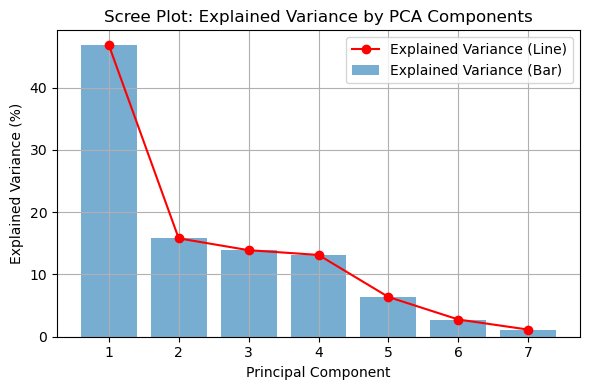

In [13]:
# Fit PCA without specifying n_components to get all components
pca_full = PCA()
pca_full.fit(X_scaled)
explained = pca_full.explained_variance_ratio_ * 100

plt.figure(figsize=(6, 4))
components = range(1, len(explained) + 1)

# Plot bars
plt.bar(components, explained, alpha=0.6, label='Explained Variance (Bar)')

# Plot line for explained variance
plt.plot(components, explained, marker='o', linestyle='-', color='r', label='Explained Variance (Line)')

plt.title('Scree Plot: Explained Variance by PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(components)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Apply PCA with 4 components
pca = PCA(n_components=4)
pca_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2', 'PC3','PC4'])

# Explained variance
explained_variance_pct = pca.explained_variance_ratio_ * 100
total_variance = explained_variance_pct.sum()
print("\nTotal Explained Variance by First 4 Components: {:.1f}%".format(total_variance))

# PCA component loadings
print("\nPCA Component Loadings:")
loadings = pd.DataFrame(pca.components_, columns=continuous_cols, index=['PC1', 'PC2', 'PC3','PC4'])
print(loadings)


Total Explained Variance by First 4 Components: 89.7%

PCA Component Loadings:
     Duration_Years  Tuition_USD  Living_Cost_Index  Rent_USD  Visa_Fee_USD  \
PC1        0.039285     0.439024           0.461094  0.522571      0.270602   
PC2        0.652231     0.340348          -0.296600 -0.034592      0.452614   
PC3       -0.692552     0.145239          -0.082481 -0.040336      0.633216   
PC4       -0.185365    -0.033874           0.180156  0.108400     -0.235187   

     Insurance_USD  Exchange_Rate  
PC1       0.471944      -0.155144  
PC2      -0.183290       0.362127  
PC3      -0.280413       0.106077  
PC4       0.185353       0.911382  


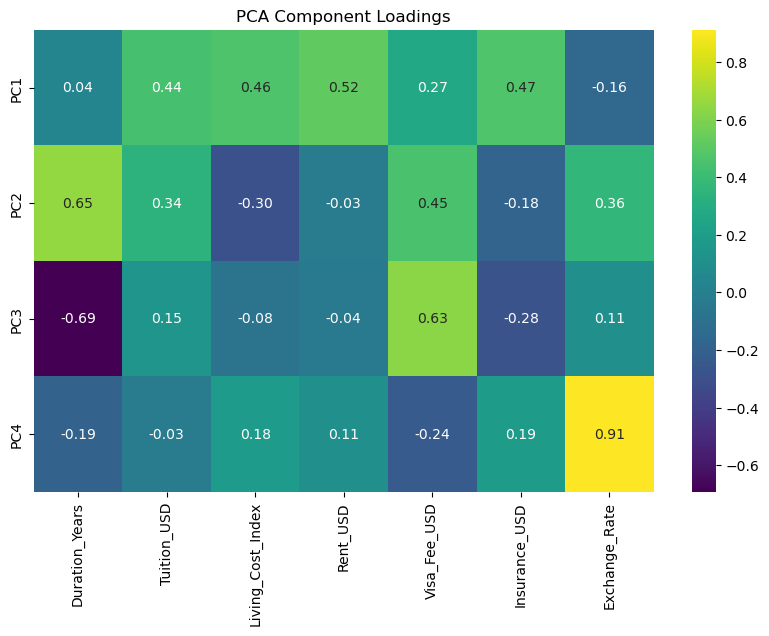

In [15]:
# Heatmap of the PCA component loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='viridis', fmt='.2f')
plt.title('PCA Component Loadings')
plt.show()

##Factor Analysis

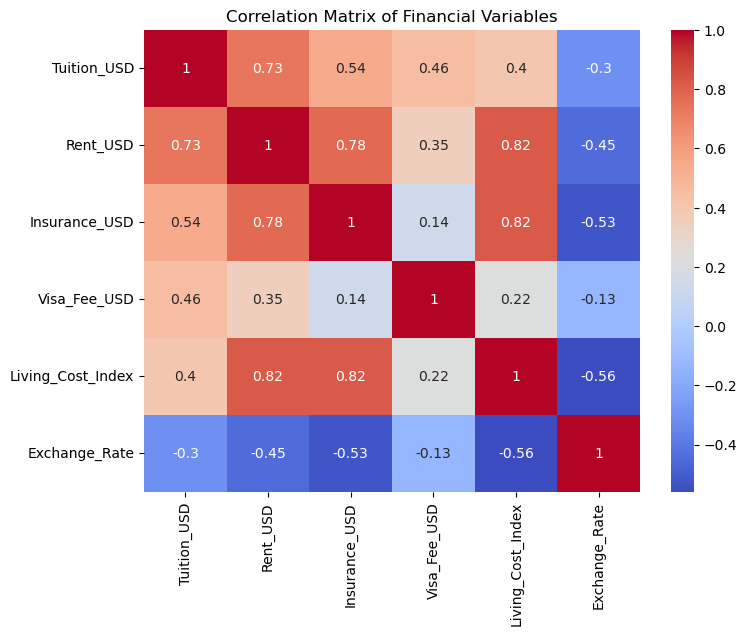

KMO Test Value: 0.68
Bartlett’s test: chi-square = 2817.63 p-value = 0.0


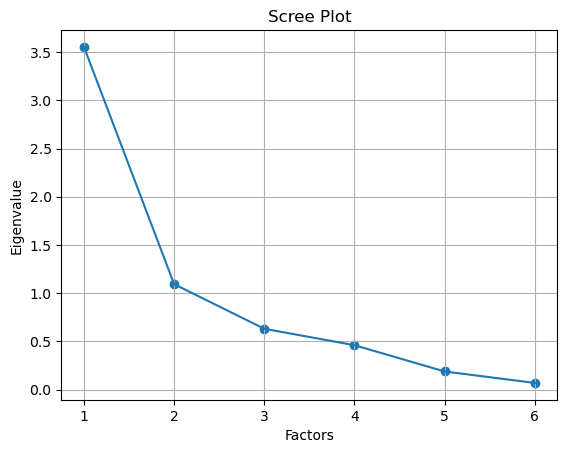


Factor Loadings:
                    Factor1  Factor2
Tuition_USD          0.284    0.957
Rent_USD             0.740    0.557
Insurance_USD        0.834    0.282
Visa_Fee_USD         0.106    0.446
Living_Cost_Index    0.948    0.171
Exchange_Rate       -0.558   -0.139

Variance Explained:
                 Factor1  Factor2
SS Loadings       2.545    1.552
Proportion Var    0.424    0.259
Cumulative Var    0.424    0.683


In [16]:
financial_cols = [
    'Tuition_USD', 'Rent_USD', 'Insurance_USD', 'Visa_Fee_USD', 'Living_Cost_Index', 'Exchange_Rate']
df_fa = df[financial_cols].dropna()

# Correlation Matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_fa.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Financial Variables")
plt.show()

# KMO and Bartlett’s Test
kmo_all, kmo_model = calculate_kmo(df_fa)
print("KMO Test Value:", round(kmo_model, 2))
chi_square_value, p_value = calculate_bartlett_sphericity(df_fa)
print("Bartlett’s test: chi-square =", round(chi_square_value,2), "p-value =", round(p_value,4))

# Scree Plot
fa = FactorAnalyzer(rotation=None)
fa.fit(df_fa)
ev, v = fa.get_eigenvalues()
plt.scatter(range(1, len(ev)+1), ev)
plt.plot(range(1, len(ev)+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Factor Analysis
n_factors = 2
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(df_fa)
loadings = pd.DataFrame(fa.loadings_, index=financial_cols, columns=[f'Factor{i+1}' for i in range(n_factors)])
print("\nFactor Loadings:\n", loadings.round(3))
variance = pd.DataFrame(
    fa.get_factor_variance(),
    index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
    columns=[f'Factor{i+1}' for i in range(n_factors)]
)
print("\nVariance Explained:\n", variance.round(3))


##Discriminant Analysis (LDA)

In [17]:
# Calculate total cost for target variable
df['Total_Cost_USD'] = (df['Tuition_USD'] + (df['Rent_USD'] * 12 * df['Duration_Years']) +
    (df['Insurance_USD'] * df['Duration_Years']) + df['Visa_Fee_USD'])

#Check min and max for define the bins
#print("Min:", df['Total_Cost_USD'].min())
#print("Max:", df['Total_Cost_USD'].max())


# Define the bins and labels
bins = [0, 20000, 50000, 200000]
labels = ['Low', 'Medium', 'High']

df['cost_cat'] = pd.cut(df['Total_Cost_USD'], bins=bins, labels=labels, include_lowest=True)

# Choose features (excluding target and highly correlated columns)
categorical_cols = ['Country', 'City', 'University', 'Program', 'Level']
numerical_cols = [
    'Duration_Years', 'Tuition_USD', 'Living_Cost_Index', 'Rent_USD',
    'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate']

# Encode categorical features
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

X = df_encoded[categorical_cols + numerical_cols]
y = df['cost_cat']


# Remove missing target values
mask = y.notna()
X = X[mask]
y = y[mask]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Fit LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

print("\nDiscriminant Analysis Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Get loadings (coefficients) for each discriminant function
loadings = pd.DataFrame(
    lda.coef_.T,
    index=X_train.columns,
    columns=[f'LD{i+1}' for i in range(lda.coef_.shape[0])]
)
print("LDA Loadings (Coefficients for each Linear Discriminant Function):")
print(loadings)



Discriminant Analysis Accuracy: 0.8571428571428571

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.89      0.94        84
         Low       0.71      0.79      0.75        38
      Medium       0.80      0.85      0.83        81

    accuracy                           0.86       203
   macro avg       0.84      0.84      0.84       203
weighted avg       0.87      0.86      0.86       203

LDA Loadings (Coefficients for each Linear Discriminant Function):
                        LD1       LD2       LD3
Country           -0.026809  0.061993 -0.001063
City               0.000521 -0.000665 -0.000230
University         0.000152  0.000305 -0.000300
Program            0.007375 -0.003421 -0.006056
Level             -0.336077  0.519580  0.106604
Duration_Years     1.286223 -1.586156 -0.595334
Tuition_USD        0.000226 -0.000191 -0.000145
Living_Cost_Index  0.103693 -0.171875 -0.027506
Rent_USD           0.001928 -0.002055 -0.001

##Canonical Correlation Analysis (CCA)

Choose Two Sets of Variables

Set X (e.g., program characteristics):Duration_Years, Level, Program, University (after encoding categorical columns)

Set Y (e.g., cost variables):Tuition_USD, Rent_USD, Insurance_USD, Visa_Fee_USD, Living_Cost_Index

In [22]:
# Encode categorical variables for X set
categorical_X = ['Level', 'Program', 'University']
df_encoded = df.copy()
for col in categorical_X:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Define X and Y sets
X = df_encoded[['Duration_Years', 'Level', 'Program', 'University']]
Y = df_encoded[['Tuition_USD', 'Rent_USD', 'Insurance_USD', 'Visa_Fee_USD', 'Living_Cost_Index']]

# Drop missing values
X = X.dropna()
Y = Y.loc[X.index]  # Ensure alignment

# Standardize
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
Y_std = scaler.fit_transform(Y)

# --- Canonical Correlation Analysis ---
cca = CCA(n_components=min(X_std.shape[1], Y_std.shape[1]))
cca.fit(X_std, Y_std)
X_c, Y_c = cca.transform(X_std, Y_std)

# --- Canonical coefficients (loadings) for each variable in both sets ----
X_loadings = pd.DataFrame(
    cca.x_weights_,
    index=X.columns,
    columns=[f'U{i+1}' for i in range(cca.n_components)]
)
print("\nCanonical Coefficients for X Set (Program Characteristics):")
print(X_loadings.round(4).to_string())

x_combo = " + ".join([f"{X_loadings.iloc[i,0]:.4f}×{X.columns[i]}" for i in range(len(X.columns))])
print(f"\nU₁ = {x_combo}")

Y_loadings = pd.DataFrame(
    cca.y_weights_,
    index=Y.columns,
    columns=[f'V{i+1}' for i in range(cca.n_components)]
)
print("\nCanonical Coefficients for Y Set (Cost Variables):")
print(Y_loadings.round(4).to_string())

y_combo = " + ".join([f"{Y_loadings.iloc[i,0]:.4f}×{Y.columns[i]}" for i in range(len(Y.columns))])
print(f"\nV₁ = {y_combo}")

print('\n' + '-'*100)

# --- Correlations between each variable and each canonical variate ---
# For X variables and U (canonical variates of X)
corrs_X = np.corrcoef(X_std.T, X_c.T)[:X_std.shape[1], X_std.shape[1]:]
corrs_X_df = pd.DataFrame(corrs_X, index=X.columns, columns=[f'U{i+1}' for i in range(X_c.shape[1])])

print("\nCorrelations between X variables and canonical variates (U):")
print(corrs_X_df.round(4).to_string())

# For Y variables and V (canonical variates of Y)
corrs_Y = np.corrcoef(Y_std.T, Y_c.T)[:Y_std.shape[1], Y_std.shape[1]:]
corrs_Y_df = pd.DataFrame(corrs_Y, index=Y.columns, columns=[f'V{i+1}' for i in range(Y_c.shape[1])])

print("\nCorrelations between Y variables and canonical variates (V):")
print(corrs_Y_df.round(4).to_string())

print('\n' + '-'*100)

# --- Correlations between each X variable and all canonical variates for Y (V1, V2, ...) ---
corrs_x_all_v = np.zeros((X_std.shape[1], Y_c.shape[1]))
for i in range(X_std.shape[1]):
    for j in range(Y_c.shape[1]):
        corrs_x_all_v[i, j] = np.corrcoef(X_std[:, i], Y_c[:, j])[0, 1]
corrs_x_all_v_df = pd.DataFrame(
    corrs_x_all_v,
    index=X.columns,
    columns=[f'V{j+1}' for j in range(Y_c.shape[1])]
)
print("\nCorrelations between each X variable and all canonical variates for Y (V₁, V₂, ...):")
print(corrs_x_all_v_df.round(4).to_string())

# --- Correlations between each Y variable and all canonical variates for X (U1, U2, ...) ---
corrs_y_all_u = np.zeros((Y_std.shape[1], X_c.shape[1]))
for i in range(Y_std.shape[1]):
    for j in range(X_c.shape[1]):
        corrs_y_all_u[i, j] = np.corrcoef(Y_std[:, i], X_c[:, j])[0, 1]
corrs_y_all_u_df = pd.DataFrame(
    corrs_y_all_u,
    index=Y.columns,
    columns=[f'U{j+1}' for j in range(X_c.shape[1])]
)
print("\nCorrelations between each Y variable and all canonical variates for X (U₁, U₂, ...):")
print(corrs_y_all_u_df.round(4).to_string())




Canonical Coefficients for X Set (Program Characteristics):
                    U1      U2      U3      U4
Duration_Years -0.6829 -0.4628  0.5536  0.1142
Level           0.1248  0.4838  0.4000  0.7683
Program         0.7035 -0.3994  0.5664 -0.1577
University     -0.1525  0.6263  0.4613 -0.6097

U₁ = -0.6829×Duration_Years + 0.1248×Level + 0.7035×Program + -0.1525×University

Canonical Coefficients for Y Set (Cost Variables):
                       V1      V2      V3      V4
Tuition_USD       -0.5653 -0.5470 -0.4615 -0.1231
Rent_USD          -0.5247  0.6489 -0.0885  0.5044
Insurance_USD     -0.0678 -0.3327  0.7685  0.3140
Visa_Fee_USD      -0.0596  0.4078  0.1983 -0.7466
Living_Cost_Index  0.6301  0.0523 -0.3863  0.2728

V₁ = -0.5653×Tuition_USD + -0.5247×Rent_USD + -0.0678×Insurance_USD + -0.0596×Visa_Fee_USD + 0.6301×Living_Cost_Index

----------------------------------------------------------------------------------------------------

Correlations between X variables and canonical v

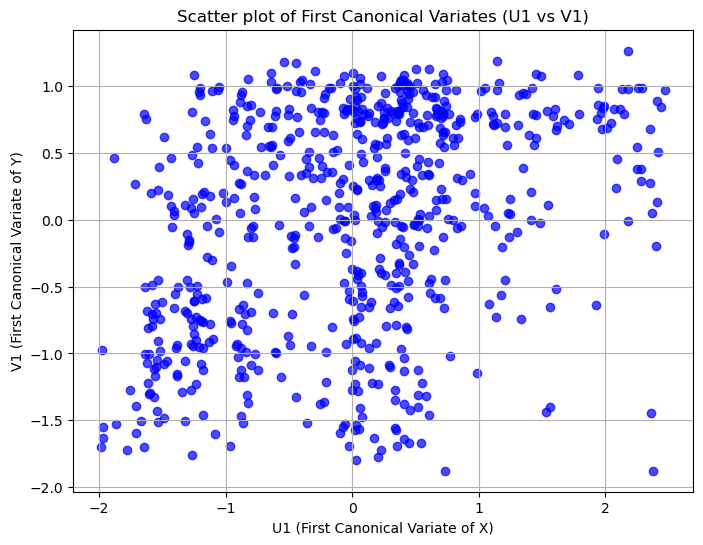

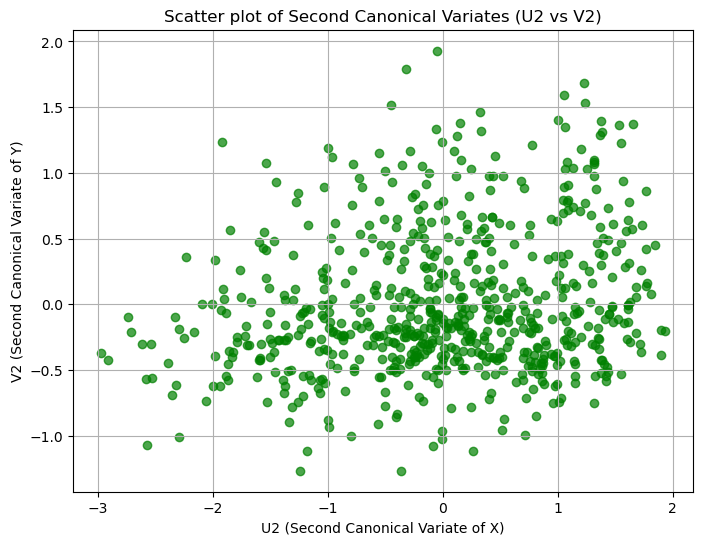

In [23]:
# Plot first canonical variates (U1 vs V1)
plt.figure(figsize=(8,6))
plt.scatter(X_c[:, 0], Y_c[:, 0], alpha=0.7, color='blue')
plt.title('Scatter plot of First Canonical Variates (U1 vs V1)')
plt.xlabel('U1 (First Canonical Variate of X)')
plt.ylabel('V1 (First Canonical Variate of Y)')
plt.grid(True)
plt.show()

# Plot second canonical variates (U2 vs V2)
plt.figure(figsize=(8,6))
plt.scatter(X_c[:, 1], Y_c[:, 1], alpha=0.7, color='green')
plt.title('Scatter plot of Second Canonical Variates (U2 vs V2)')
plt.xlabel('U2 (Second Canonical Variate of X)')
plt.ylabel('V2 (Second Canonical Variate of Y)')
plt.grid(True)
plt.show()